Correlação de Pearson: 0.60, Valor-p: 2.51e-04
Correlação de Spearman: 0.40, Valor-p: 2.28e-02
Proporção de vitórias de times com maior valor econômico: 62.97%
                            OLS Regression Results                            
Dep. Variable:       vitoria_mandante   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     95.93
Date:                Sat, 01 Feb 2025   Prob (F-statistic):           5.69e-22
Time:                        14:01:44   Log-Likelihood:                -929.63
No. Observations:                1442   AIC:                             1863.
Df Residuals:                    1440   BIC:                             1874.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t

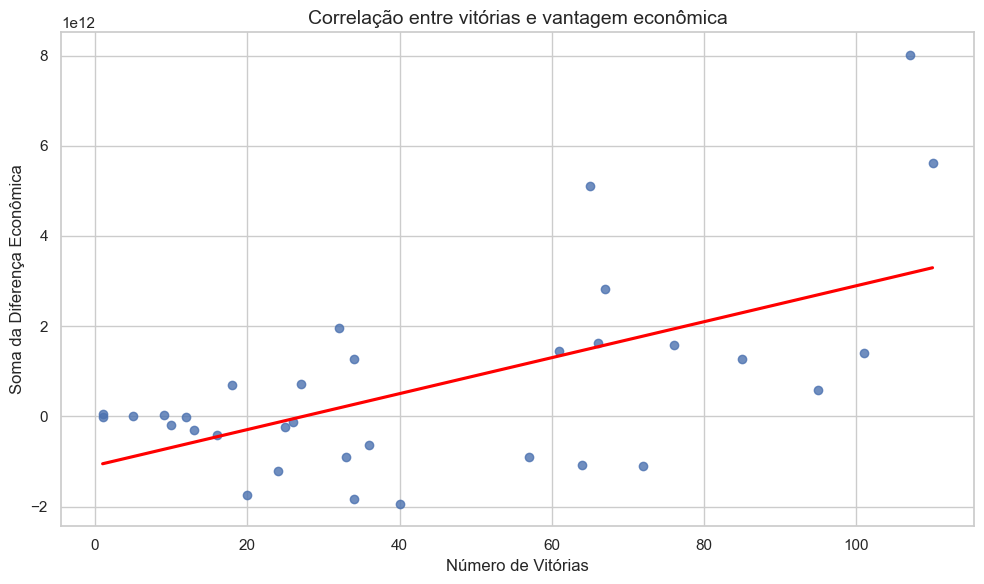

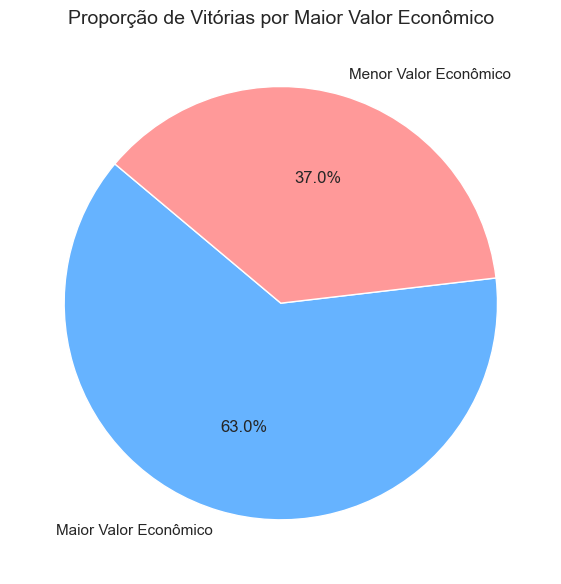

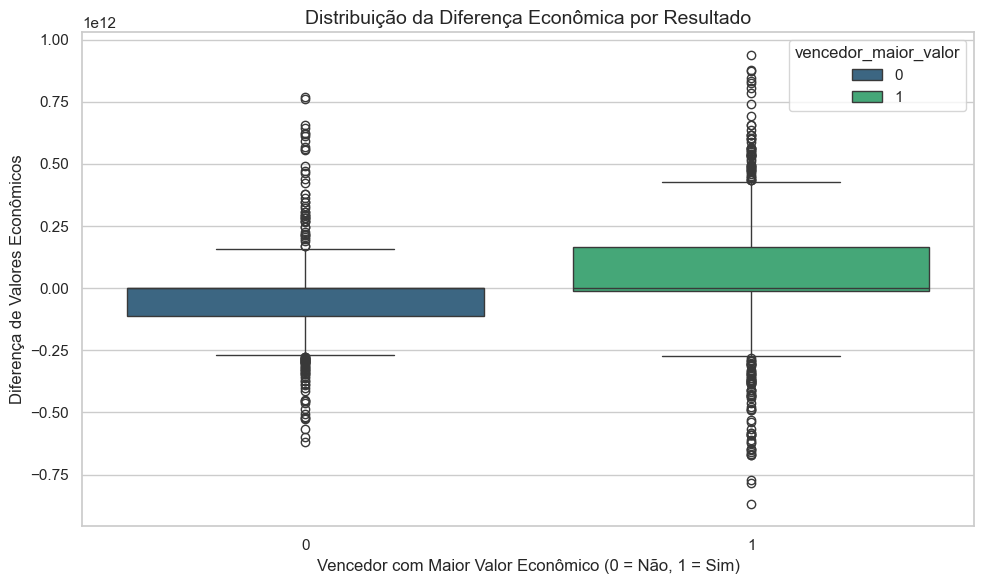

In [4]:
# Importa bibliotecas necessárias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from statsmodels.formula.api import ols
import numpy as np

# Configurações gerais
pd.options.display.float_format = '{:.2f}'.format
sns.set(style="whitegrid")

# Função para definir o vencedor do jogo
def determinar_vencedor(row):
    if row['gols_mandante'] > row['gols_visitante']:
        return row['time_mandante']
    elif row['gols_visitante'] > row['gols_mandante']:
        return row['time_visitante']
    else:
        return 'Empate'

# Carrega dataset
file_path = r"C:\Users\willi\Escalfoni GCI\base.csv"
df = pd.read_csv(file_path, encoding='utf8', delimiter=',')

# Filtra dados para os anos de 2014 a 2024 e remove valores ausentes
df = df[(df['ano_campeonato'] >= 2014) & (df['ano_campeonato'] <= 2024)].dropna()

# Colunas de interesse
manter = [
    'ano_campeonato', 
    'data', 
    'time_mandante', 
    'time_visitante', 
    'valor_equipe_titular_mandante', 
    'valor_equipe_titular_visitante', 
    'gols_mandante', 
    'gols_visitante'
]
df = df[manter]

# Ajusta valores econômicos
df['valor_equipe_titular_mandante'] *= 10000
df['valor_equipe_titular_visitante'] *= 10000

# Define o vencedor
df['vencedor_do_jogo'] = df.apply(determinar_vencedor, axis=1)
df = df[df['vencedor_do_jogo'] != 'Empate']  # Remove jogos empatados

# Adiciona diferença de valores econômicos
df['diferenca_valores'] = (
    df['valor_equipe_titular_mandante'] - df['valor_equipe_titular_visitante']
)

# Adiciona coluna para identificar se o time vencedor tinha maior poder econômico
df['vencedor_maior_valor'] = ((
    (df['vencedor_do_jogo'] == df['time_mandante']) & 
    (df['valor_equipe_titular_mandante'] > df['valor_equipe_titular_visitante'])
) | (
    (df['vencedor_do_jogo'] == df['time_visitante']) &
    (df['valor_equipe_titular_visitante'] > df['valor_equipe_titular_mandante'])
)).astype(int)

# Agrupamento por time
agrupado = df.groupby('vencedor_do_jogo').agg(
    vitorias=('vencedor_do_jogo', 'count'),
    valor_total=('diferenca_valores', 'sum')
).reset_index()

# Teste de correlação (Pearson e Spearman)
pearson_corr, p_pearson = pearsonr(agrupado['vitorias'], agrupado['valor_total'])
spearman_corr, p_spearman = spearmanr(agrupado['vitorias'], agrupado['valor_total'])

print(f"Correlação de Pearson: {pearson_corr:.2f}, Valor-p: {p_pearson:.2e}")
print(f"Correlação de Spearman: {spearman_corr:.2f}, Valor-p: {p_spearman:.2e}")

# Análise de proporção de vitórias
proporcao = df['vencedor_maior_valor'].mean() * 100
print(f"Proporção de vitórias de times com maior valor econômico: {proporcao:.2f}%")

# Modelo de regressão linear
df_regressao = df.copy()
df_regressao['vitoria_mandante'] = (df['vencedor_do_jogo'] == df['time_mandante']).astype(int)
modelo = ols('vitoria_mandante ~ diferenca_valores', data=df_regressao).fit()
print(modelo.summary())

# Geração de gráficos
# Gráfico 1: Scatterplot com linha de regressão
plt.figure(figsize=(10, 6))
sns.regplot(x="vitorias", y="valor_total", data=agrupado, ci=None, line_kws={"color": "red"})
plt.title("Correlação entre vitórias e vantagem econômica", fontsize=14)
plt.xlabel("Número de Vitórias", fontsize=12)
plt.ylabel("Soma da Diferença Econômica", fontsize=12)
plt.tight_layout()
plt.savefig("correlacao_vitorias_economia.png")
plt.show()

# Gráfico 2: Proporção de vitórias por maior valor econômico
plt.figure(figsize=(8, 6))
labels = ['Maior Valor Econômico', 'Menor Valor Econômico']
sizes = [df['vencedor_maior_valor'].sum(), len(df) - df['vencedor_maior_valor'].sum()]
colors = ['#66b3ff', '#ff9999']
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title("Proporção de Vitórias por Maior Valor Econômico", fontsize=14)
plt.tight_layout()
plt.savefig("proporcao_vitorias_economia.png")
plt.show()

# Gráfico 3: Boxplot da diferença de valores entre vencedores e perdedores
plt.figure(figsize=(10, 6))
sns.boxplot(
    x='vencedor_maior_valor', 
    y='diferenca_valores', 
    data=df, 
    hue='vencedor_maior_valor',
    palette="viridis"
)

plt.title("Distribuição da Diferença Econômica por Resultado", fontsize=14)
plt.xlabel("Vencedor com Maior Valor Econômico (0 = Não, 1 = Sim)", fontsize=12)
plt.ylabel("Diferença de Valores Econômicos", fontsize=12)
plt.tight_layout()
plt.savefig("boxplot_diferenca_valores.png")
plt.show()
